In [1]:
import torch
from torch import nn
import os
import pickle
import tqdm

In [2]:
from vb import CustomDataset
import torchaudio

In [3]:
# train_dataset = CustomDataset(train=True, target_len=2**13)
# test_dataset = CustomDataset(train=False, target_len=2**13, fixed=True)


In [4]:

# with open('train_dataset.pkl', 'wb') as f:
#     pickle.dump(train_dataset, f, pickle.HIGHEST_PROTOCOL)

# with open('test_dataset.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f, pickle.HIGHEST_PROTOCOL)


In [5]:
with open('train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

In [6]:
from torch import nn
import torch


class CBP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CBP, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, 3, 1, padding=1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.prelu = nn.PReLU()
    def forward(self, x, residual=None):
        x = self.conv(x)
        x = self.bn(x)
        if residual==None:
            x = self.prelu(x)
        else:
            x = self.prelu(x+residual)
        return x
        
class Pool(nn.Module):
    def __init__(self, in_channels):
        super(Pool, self).__init__()
        self.conv = nn.Conv1d(in_channels, in_channels, 2, 2, padding=0)
        self.bn = nn.BatchNorm1d(in_channels)
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        
        return x
        
        
class unPool(nn.Module):
    def __init__(self, in_channels):
        super(unPool, self).__init__()
        self.tconv = nn.ConvTranspose1d(in_channels, in_channels, 2, 2)
        self.bn = nn.BatchNorm1d(in_channels)
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        x = self.tconv(x)
        x = self.bn(x)
        x = self.prelu(x)
        
        return x
          
        
        
        
        
        

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        
        self.residual = nn.Conv1d(in_channels, out_channels, 1)  # Skip connection
        self.cbp11 = CBP(in_channels, out_channels)
        self.cbp12 = CBP(out_channels, out_channels)
        
        self.cbp21 = CBP(out_channels, out_channels)
        self.cbp22 = CBP(out_channels, out_channels)
        
        self.pool = Pool(out_channels)
        
        
    def forward(self, x):
        residual = self.residual(x)
        x = self.cbp11(x)
        residual = self.cbp12(x, residual)
        
        x = self.cbp21(residual)
        skip = self.cbp22(x, residual)
        
        x = self.pool(skip)
        
        return x, skip

    
    
    
    
    
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.unpool = unPool(in_channels)
        self.residual = nn.Conv1d(in_channels, out_channels, 1)  # Skip connection
        
        self.cbp11 = CBP(in_channels*2, out_channels)
        self.cbp12 = CBP(out_channels, out_channels)
        
        self.cbp21 = CBP(out_channels, out_channels)
        self.cbp22 = CBP(out_channels, out_channels)
        
    def forward(self, x, skip):
        
    
        x = self.unpool(x)
        residual = self.residual(x)
        x = self.cbp11(torch.cat([x, skip], dim=1))
        residual = self.cbp12(x, residual)
    
        x = self.cbp21(residual)
        x = self.cbp22(x, residual)
        
        return x


class Feature_Encoder(nn.Module):
    def __init__(self):
        super(Feature_Encoder, self).__init__()
        # Encoder blocks
        self.encoder_block_1 = Encoder(1, 8)
        self.encoder_block_2 = Encoder(8, 8)
        self.encoder_block_3 = Encoder(8, 16)
        self.encoder_block_4 = Encoder(16, 32)
        self.encoder_block_5 = Encoder(32, 64)

        # Decoder blocks
        self.decoder_block_5 = Decoder(64, 32)
        self.decoder_block_4 = Decoder(32, 16)
        self.decoder_block_3 = Decoder(16, 8)
        self.decoder_block_2 = Decoder(8, 8)
        self.decoder_block_1 = Decoder(8, 8)
        
        self.conv1 = nn.Conv1d(8, 16, 3, 1, padding=1)  # Remove dilation
        self.conv2 = nn.Conv1d(16, 32, 3, 1, padding=1)  # Remove dilation
        self.conv3 = nn.Conv1d(32, 64, 3, 1, padding=1)
        self.conv4 = nn.Conv1d(64, 128, 3, 1, padding=1)
        self.conv7 = nn.Conv1d(128, 1, 1, 1)

        
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()
        self.prelu4 = nn.PReLU()
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        out, skip1 = self.encoder_block_1(x)
        out, skip2 = self.encoder_block_2(out)
        out, skip3 = self.encoder_block_3(out)
        out, skip4 = self.encoder_block_4(out)
        out, skip5 = self.encoder_block_5(out)
        
        out = self.decoder_block_5(out, skip5)
        out = self.decoder_block_4(out, skip4)
        out = self.decoder_block_3(out, skip3)
        out = self.decoder_block_2(out, skip2)
        out = self.decoder_block_1(out, skip1)

        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.prelu2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.prelu3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.prelu4(out)

        out = self.conv7(out)

        return self.tanh(out)

model = Feature_Encoder()
sample_input = torch.randn(64, 1, 8192)
model(sample_input)
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_parameters

152463

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True,drop_last=True)
device = 'cuda'

In [9]:

from torch.utils.tensorboard import SummaryWriter

device = 'cuda'
model = Feature_Encoder().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

writer = SummaryWriter('boards/0_2M_unet_tanh')
x_back = None
l_list = []
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('trainable parameters:', trainable_parameters)
for epoch in range(0,100000000000):
    t_loss = 0
    model.train()
    for clean, noisy in train_loader:
        clean, noisy = clean.to(device), noisy.to(device)
        
        pred = model(noisy)
        
        loss = loss_fn(pred, clean)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss+=loss.item()
    # l_list.append(t_loss)
    t_loss /= len(train_loader)
    
    
    
    model.eval()
    with torch.no_grad():
        t_tloss = 0
        for clean, noisy in test_loader:
            clean, noisy = clean.to(device), noisy.to(device)
            pred = model(noisy)
            loss = loss_fn(pred, clean)
            t_tloss+=loss.item()
        # l_list.append(t_tloss)
        t_tloss /= len(test_loader)
        
    writer.add_scalars('run_14h', {'train_loss':t_loss,
                                        'test_loss':t_tloss}, epoch)
    writer.flush()
    if epoch%10==1:
        print(epoch, t_loss, t_tloss)
        try:
            os.mkdir("ckpts/0_2M_unet_tanh")
        except:
            pass
        torch.save(model.state_dict(), f'ckpts/0_2M_unet_tanh/ckpt_{epoch}_.pt')

writer.close()

trainable parameters: 152463
1 0.01415960396019121 0.008572453322509924
11 0.0019857671849119168 0.001487460588881125
21 0.001411585031180746 0.0010223214922007173
31 0.0011598422043284195 0.0007538842764915898
41 0.0009547142683812935 0.000536460679237886
51 0.0008529937298994304 0.0004831168213665175
61 0.0007643143389335212 0.00036831182418003056
71 0.0006997494481361678 0.0003319732034772945
81 0.0006733991217010447 0.0003191061684143885
91 0.0006236934751440357 0.00028922786320132826
101 0.0006136030151133633 0.0002658578559930902
111 0.0005879074456364227 0.00026308737627308193


KeyboardInterrupt: 

In [11]:
DATASET_PATH = "/workspace/nas-dataset/jis/voicebank_demand/"


noisy_path = os.path.join(DATASET_PATH, 'noisy_trainset_28spk_wav')
file_lists = os.listdir(noisy_path)

In [13]:
import librosa
noisy, sr2 = librosa.load(os.path.join(noisy_path, file_lists[0]), sr=16000,res_type='kaiser_best')

In [16]:
import numpy as np
pad_size = len(noisy)%8192
padded_noisy = np.pad(noisy, (0, 8192-pad_size), 'constant', constant_values=(0, 0))

In [18]:
pred = model(torch.tensor(padded_noisy).float().view(1,1,-1).to(device)).cpu().detach().numpy().reshape(-1)

In [20]:
import matplotlib.pyplot as plt
import IPython.display as ipd

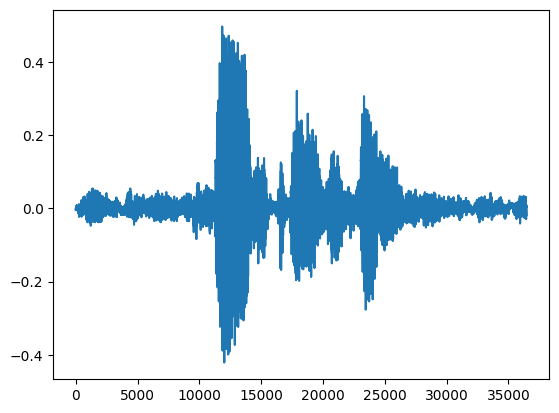

In [23]:
plt.plot(noisy)
plt.show()
ipd.display(ipd.Audio(noisy, rate=16000))

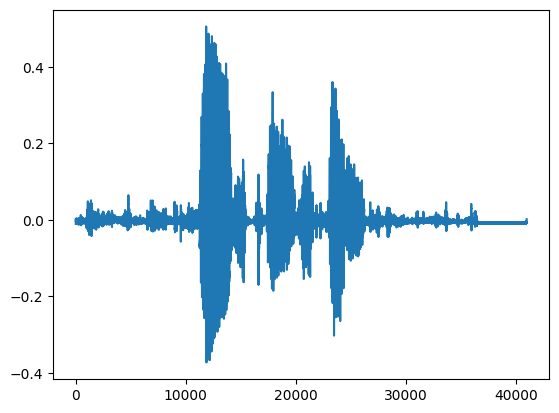

In [24]:
plt.plot(pred)
plt.show()
ipd.display(ipd.Audio(pred, rate=16000))

In [25]:
with open("data/test_dataset.txt", 'r') as f:
    test_list = f.readlines()
    test_list = [x.strip() for x in test_list]

In [ ]:
with open("data/test_dataset.txt", 'r') as f:
    test_list = f.readlines()
    test_list = [x.strip() for x in test_list]

clean_path = "/workspace/nas-dataset/jis/voicebank_demand/clean_trainset_56spk_wav/"
noisy_path = "/workspace/nas-dataset/jis/voicebank_demand/noisy_trainset_56spk_wav/"
x1_path = "/workspace/nas-dataset/jis/VB_readymade/sample_enh/0_2M_unet/"
try:
    os.mkdir(x1_path)
except:
    pass

model.load_state_dict(torch.load('ckpts/0_2M_unet_tanh/ckpt_111_.pt'))
model.eval()
with torch.no_grad():
    for i, file in enumerate(tqdm.tqdm(test_list)):
        clean, sr1 = librosa.load(os.path.join(clean_path, file), sr=16000,res_type='kaiser_best')
        noisy, sr2 = librosa.load(os.path.join(noisy_path, file), sr=16000,res_type='kaiser_best')
        
        pad_size = 8192 - len(noisy)%8192
        padded_noisy = np.pad(noisy, (0, pad_size), 'constant', constant_values=(0, 0))
        x1 = model(torch.tensor(padded_noisy).float().view(1,1,-1).to(device)).cpu().detach().numpy().reshape(-1)[:len(clean)]
        
        torchaudio.save(os.path.join(x1_path, file), torch.tensor(x1).view(1,-1), 16000)
        
        # break

100%|██████████| 835/835 [01:31<00:00,  9.09it/s]


In [44]:
len(padded_noisy)%2**13

5102

In [34]:
ipd.display(ipd.Audio(x1, rate=16000))

In [46]:
gas = 107010
electricity = 34980
rent = 560000

In [47]:
rent/2 - gas/2 - electricity/2

209005.0

In [11]:
with open("data/test_dataset.txt", 'r') as f:
    test_list = f.readlines()
    test_list = [x.strip() for x in test_list]

clean_path = "/workspace/nas-dataset/jis/voicebank_demand/clean_trainset_56spk_wav/"
noisy_path = "/workspace/nas-dataset/jis/voicebank_demand/noisy_trainset_56spk_wav/"
x1_path = "/workspace/nas-dataset/jis/VB_readymade/sample_enh/0_2M_unet/"
x2_path = "/workspace/nas-dataset/jis/VB_readymade/sample_enh/x2_0_2M_unet/"
x3_path = "/workspace/nas-dataset/jis/VB_readymade/sample_enh/x3_0_2M_unet/"

import librosa
import numpy as np
device = 'cuda'
model = model.to(device)
try:
    os.mkdir(x3_path)
except:
    pass

model.load_state_dict(torch.load('ckpts/0_2M_unet_tanh/ckpt_111_.pt'))
model.eval()
with torch.no_grad():
    for i, file in enumerate(tqdm.tqdm(test_list)):
        clean, sr1 = librosa.load(os.path.join(clean_path, file), sr=16000,res_type='kaiser_best')
        noisy, sr2 = librosa.load(os.path.join(x2_path, file), sr=16000,res_type='kaiser_best')
        
        pad_size = 8192 - len(noisy)%8192
        padded_noisy = np.pad(noisy, (0, pad_size), 'constant', constant_values=(0, 0))
        x1 = model(torch.tensor(padded_noisy).float().view(1,1,-1).to(device)).cpu().detach().numpy().reshape(-1)[:len(clean)]
        
        torchaudio.save(os.path.join(x3_path, file), torch.tensor(x1).view(1,-1), 16000)
        
        # break

  0%|          | 0/835 [00:00<?, ?it/s]

100%|██████████| 835/835 [00:56<00:00, 14.79it/s]
